# Tutorial Image-Scaling Attacks and Defenses
In this short notebook, I will show you how easy it is to load two images and to run an image-scaling attack.

## 1. Load library and images
First, let's load what we need.

In [1]:
from utils.plot_image_utils import plot_images_in_actual_size

from scaling.ScalingGenerator import ScalingGenerator
from scaling.SuppScalingLibraries import SuppScalingLibraries
from scaling.SuppScalingAlgorithms import SuppScalingAlgorithms
from scaling.ScalingApproach import ScalingApproach
from attack.QuadrScaleAttack import QuadraticScaleAttack
from attack.ScaleAttackStrategy import ScaleAttackStrategy
from utils.load_image_data import load_image_examples

We need a source image and target image. We use a cat and coffee image here.
I've reduced the image size of the cute cat to (60, 90, 3) pixels to speed up the attack. In practice,
the target size depends on the input size of your system / machine learning classifier.

If you load images, please keep the root-cause analysis in mind.
- The scaling ratio needs to be large enough
- Choose the right scaling algorithm and library

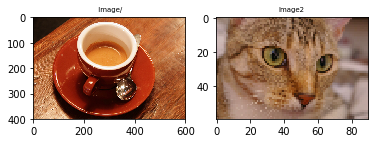

In [2]:
src_image_example, tar_image_example = load_image_examples(img_src=2)

## 2. Parameters
Next, let's choose the scaling algorithm and library to be used.

In [3]:
# Let's use the nearest scaling algorithm which is often the default algorithm.
scaling_algorithm: SuppScalingAlgorithms = SuppScalingAlgorithms.NEAREST
# We support OpenCV, Pillow or TensorFlow (consider that Pillow has a 'secure' scaling behaviour for
# Linear and Cubic, see Sec. 4.2 USENIX Security'20 paper)
scaling_library: SuppScalingLibraries = SuppScalingLibraries.CV

We select Nearest Neighbor and OpenCV as scaling algorithm and library, respectively.
In the next step, we just need to generate a scaling object that saves the scaling matrices (so properties
what our attack needs)

In [4]:
scaler_approach: ScalingApproach = ScalingGenerator.create_scaling_approach(
    x_val_source_shape=src_image_example.shape,
    x_val_target_shape=tar_image_example.shape,
    lib=scaling_library,
    alg=scaling_algorithm
)

## 3. Attack
Now let's start the attack.
By choosing an epsilon value of 1, the maximum difference between the downscaled attack image and our target image should be 1. The attack may need some minutes. Set verbose to True if you want to see the progress.

In [5]:
scale_att: ScaleAttackStrategy = QuadraticScaleAttack(eps=1, verbose=False)

result_attack_image, _, _ = scale_att.attack(src_image=src_image_example,
                                             target_image=tar_image_example,
                                             scaler_approach=scaler_approach)

Let's plot the images.
A succesful attack is characterized by two goals (see paper, Section 2.2.1).
- O1: The downscaled attack image should correspond to the target image
- O2: The attack image should correspond to the original source image

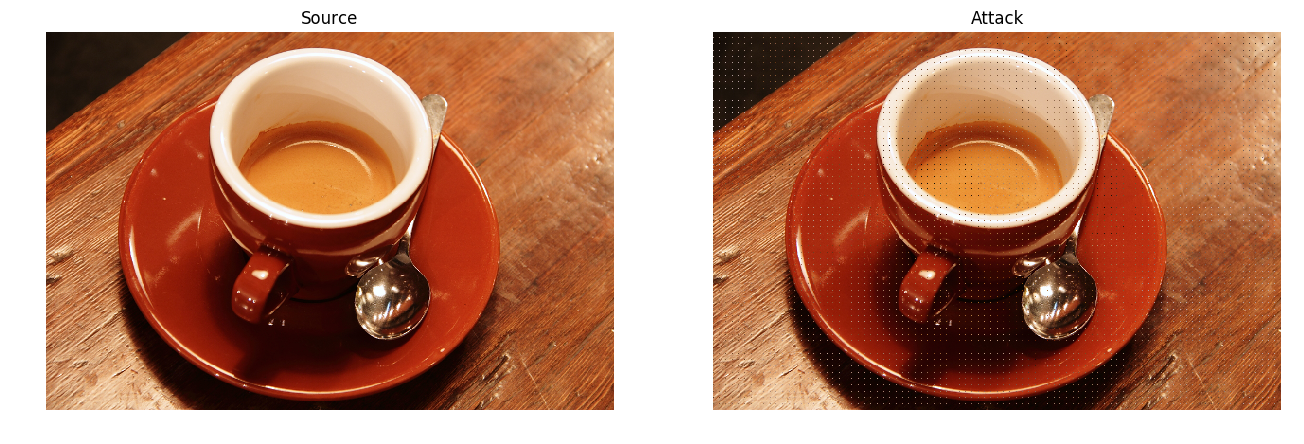

In [6]:
# Let's first analyze O2
plot_images_in_actual_size(imgs=[src_image_example, result_attack_image], titles=["Source", "Attack"], rows=1)

The attack image looks like the source image. No obvious traces of an attack!
Both show the coffee mug, and not the cat image!

<sub>(Depending on your screen and jupyter notebook, jupyter will scale the attack image to plot it: so you may see some noise; if so, try to open the image outside of jupyter).<sub>

**But what happens if we scale the attack image?**

In [7]:
# To this end, let's scale down the attack image, as we would do in a real machine learning pipeline.
result_output_image = scaler_approach.scale_image(xin=result_attack_image)

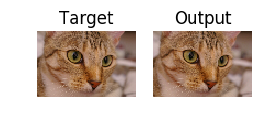

In [8]:
# Let's analyze O1
plot_images_in_actual_size(imgs=[tar_image_example, result_output_image], titles=["Target", "Output"], rows=1)

We do not obtain a smaller version of the coffee mug, as we would expect. 
We obtain a cat, exactly as the target image. We thus achieve goal O1. 
This output image may used then by neural networks or another systems, allowing novel attacks to mislead classifiers or to perform poisoning attacks.

That's it. We do not need more for an image-scaling attack. Now you can load your own images, but please consider that the scaling ratio needs to be large enough. For nearest scaling, a good ratio is usually >= 5. It depends on the image of course. You may choose a larger ratio, e.g. between 5 and 10 depending on the source and target image.
In other words, the source image should be 5x-10x larger than the target image at least.

**Next steps**: Please look at the tutorial directory. There you can find python files that introduce the different attacks and defenses.